# Project 2: Adding Machine

### Brief Project Description

In this project, we build a feedforward neural network (FFN) capable of adding two integers between -10 and 10. To ensure the consistency of our results, we conduct an experiment by constructing the same model architecture ten times and evaluating the obtained results.

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

## Create and Process the Data

In [193]:
def dataGenerating():
    """ 
    Function that generates the required data 
    and returns it as a Pandas DataFrame. 
    """
    
    # generate the data
    dataSize = 2000
    firstNumber = np.random.randint(-10,high=11,size=dataSize)
    secondNumber = np.random.randint(-10,high=11,size=dataSize)
    result = firstNumber + secondNumber 

    # create a dataframe to store the data
    data = {'First Number': firstNumber, 'Second Number': secondNumber, 'Result': result}
    data = pd.DataFrame(data)
    
    return data 
    
# provide an example of how the data looks    
data = dataGenerating()
data.head()

,First Number,Second Number,Result
0,-5,9,4
1,-5,-4,-9
2,-4,-10,-14
3,-2,-1,-3
4,4,-4,0


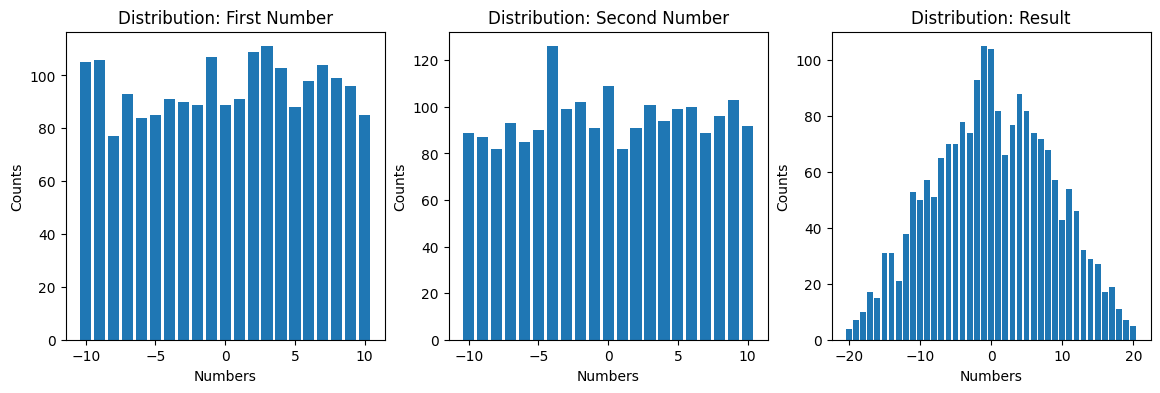

In [194]:
# for validation, we plot the distributions of the generated numbers.
fig, ax = plt.subplots(1,3, figsize=(14,4))

for i in range(len(ax)):

    valueCounts = data[data.keys()[i]].value_counts().sort_index()
    ax[i].bar(valueCounts.index,valueCounts.values)
    ax[i].set_title(f'Distribution: {data.keys()[i]}')
    ax[i].set_xlabel('Numbers')
    ax[i].set_ylabel('Counts')
    

In [195]:
def dataConvert():
    """
    Function that converts the data into the required format.
    """
    
    # generate the data
    data = dataGenerating()
    
    # convert the data into Pytorch tensors
    dataT = torch.tensor(data.drop('Result', axis=1).values).float()
    labelT = torch.tensor(data['Result'].values).float()
    labelT = torch.reshape(labelT, (len(labelT),1))

    # use sklearn to split the data into train
    train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelT, test_size=0.2)

    # convert them into PyTrch datasets
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)
                          
    # convert them into PyTorch daaloader objects
    batchsize = 32
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return  dataT, labelT, train_data, test_data, train_loader,  test_loader  

## Create the Model

In [196]:
def createTheModel():
    
    class AdditionModel(nn.Module):
        def __init__(self):
            super().__init__()
            
            # input layer
            self.input = nn.Linear(2,32)
            
            # hidden layer
            self.fc1 = nn.Linear(32,64)
            self.fc2 = nn.Linear(64,32)
            
            # output layer 
            self.output = nn.Linear(32,1)
            
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)
        
    # create a model instance
    net = AdditionModel()
    
      # lossfunction
    lossfun = nn.MSELoss()
    
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-3)
    
    return net, lossfun, optimizer       

## Train the Model

In [197]:
def trainTheModel():
    
    # number of epochs
    numepochs = 10
    
    # create a model
    net, lossfun, optmizer = createTheModel()
    
    # create the required datasets and dataloader objects
    _, _, train_data, test_data, train_loader, test_loader = dataConvert()
    
    # initialize loss
    losses = torch.zeros(numepochs)
    
    
    # loop over training epochs
    for epochi in range(numepochs):
        
        # switch on train mode
        net.train()
        
        # loop over batch
        batchLoss = []
        
        for X,y in train_loader:
            
            # forward 
            yHat = net(X)
            loss = lossfun(yHat,y)
            
            # backward
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()
            
            # compute loss
            batchLoss.append(loss.item())
            
        # end batch loop
        
        # now we have trained trough the batches, get their accuracy
        losses[epochi]= np.mean(batchLoss)
    
    # final forward pass
    with torch.no_grad():
        predictions = net(train_data.tensors[0])
    
    # compute the train accuracy
    trainAcc =  100*torch.mean((torch.round(predictions)==train_data.tensors[1]).float()).item()
    
    # evaluate model and compute the accuracy
    with torch.no_grad():
        predictions = net(test_data.tensors[0])
        
    testAcc =  100*torch.mean((torch.round(predictions)==test_data.tensors[1]).float()).item()
     
    # function output
    return losses, trainAcc, testAcc, net

## Run the experiment

In [198]:
for i in range(0,10):
    _, trainAcc, testAcc, _ =  trainTheModel()
    print('Model instance, final TRAIN/TEST accuracies:', (i+1,trainAcc,testAcc))
    

Model instance, final TRAIN/TEST accuracies: (1, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (2, 99.25000071525574, 99.25000071525574)
Model instance, final TRAIN/TEST accuracies: (3, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (4, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (5, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (6, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (7, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (8, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (9, 100.0, 100.0)
Model instance, final TRAIN/TEST accuracies: (10, 100.0, 100.0)


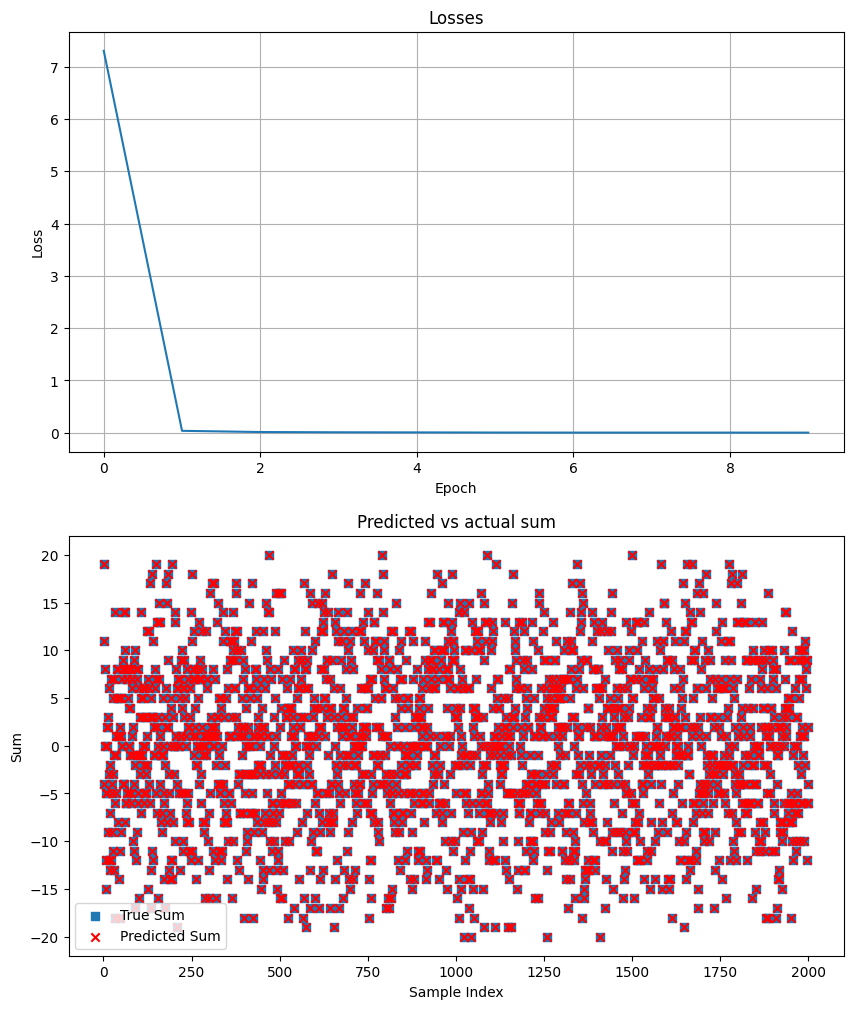

In [199]:
# get the losses and the trained net
losses, _, _, net =  trainTheModel()

# create the required datasets and dataloader objects
dataT, labelT, _, _, _,_ = dataConvert()

# predict the test values
prediction = torch.round(net(dataT).detach())
groundTruth = labelT 


# plot some results
fig, ax = plt.subplots(2,1, figsize=(10,12))
ax[0].plot(losses)
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].scatter(np.arange(1,2001), groundTruth, marker='s')
ax[1].scatter(np.arange(1,2001), prediction, marker='x', color='r')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Sum')
ax[1].set_title('Predicted vs actual sum')
ax[1].legend(['True Sum', 'Predicted Sum'])


plt.show()

## References

https://www.udemy.com/course/deeplearning_x/